<a href="https://colab.research.google.com/github/YunseolPark/GenePredictionWorkshop/blob/main/%5B2020_01_25%5DGenePredictionWorkshop_ParkYunseol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Translation Initiation Site Prediction Using Synthetic Datasets**

### Yunseol Park


---


## Contents
1.   Introduction
2.   Importing datasets
3.   Building the prediction model network
4.   Preparation for training
5.   Training and evaluating a prediction model
6.   Feature analysis

## 1. Introduction


Translation initiation sites (TISs) can give insight into the mechanism of  translation and the proteins synthesized by certain mRNAs. Thus, its prediction is important for genome analysis.

We will take a look at a TIS prediction model and some feature analysis methods to study more indepth on this topic.

Often, a gene prediction model is built with convolutional neural networks (CNNs). It takes DNA sequences as inputs and learns their features to make accurate decisions on separate test sets.

Below, you can see an image of a TIS prediction model.

<br/>

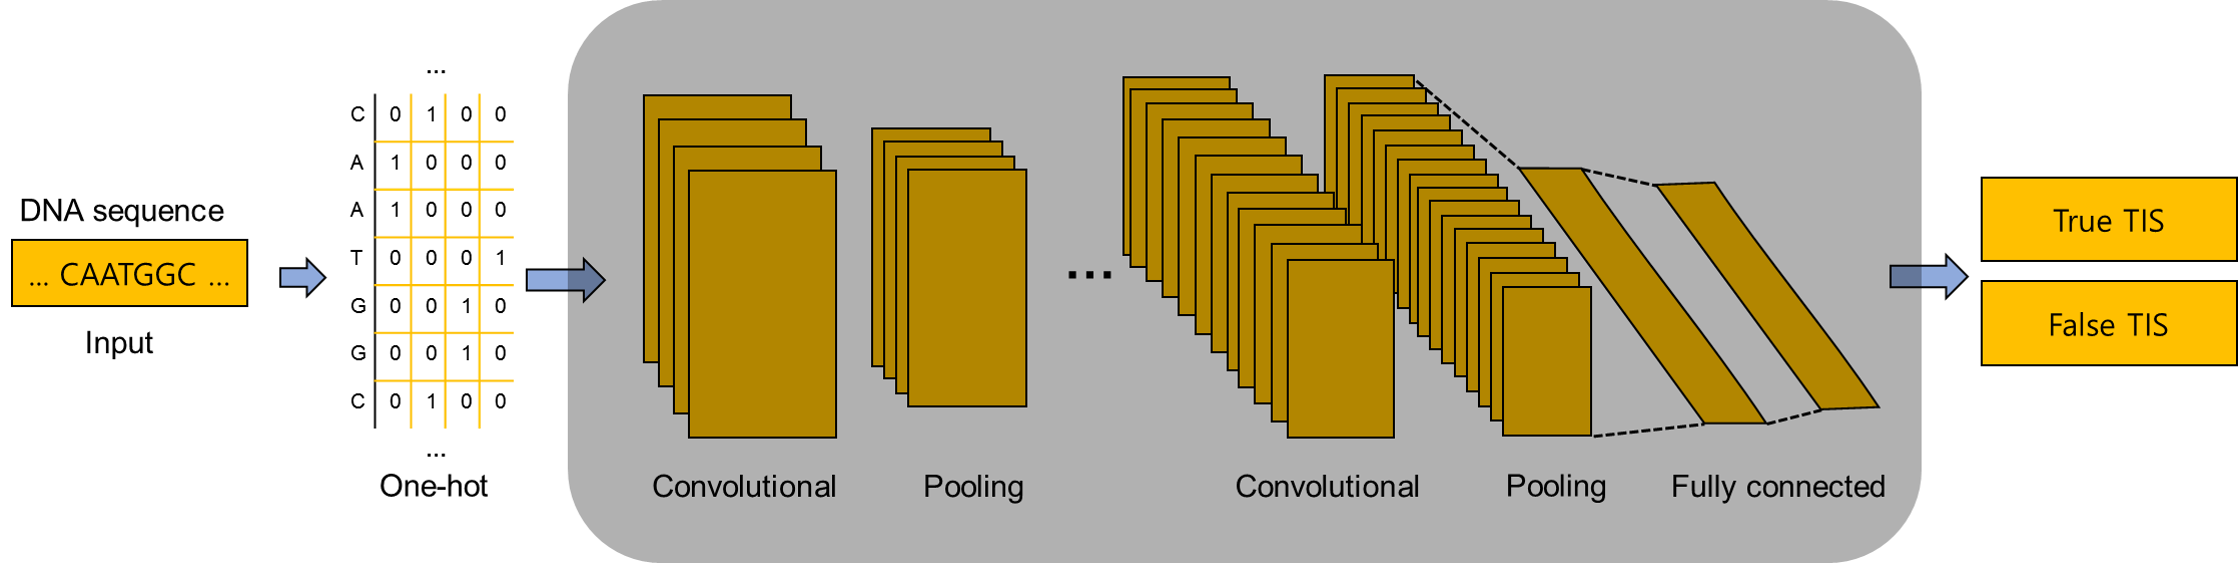

## 2. Importing datasets



In [1]:
from google.colab import files
uploaded = files.upload()

Saving arabTIS_train.neg to arabTIS_train.neg
Saving arabTIS_train.pos to arabTIS_train.pos
Saving arabTIS_val.neg to arabTIS_val.neg
Saving arabTIS_val.pos to arabTIS_val.pos
Saving at_neg_test.txt to at_neg_test.txt
Saving at_pos_test.txt to at_pos_test.txt


## 2. Building the prediction model network

As genetic information, stored in the form of DNAs, is a series of letters, it is necessary to convert this into one-hot encoded data in order to feed it to a prediction model.

The code below uses torch to build a dataset of one-hot encoded DNA sequences.

In [ ]:
import numpy as np
import torch
import random
from torch.utils.data.dataset import Dataset

In [ ]:
class TISDataset(Dataset):
    """
    Class to generate TIS dataset for dataloader
    """

    def read_dna(self, file, class_id):
        """
        Reads DNA files and save to a list of sequences

        Args:
            file: file that contains DNA sequences
            class_id: class of the sequence file (positive: 1, negative: 0)
        Return:
            List that contains tuples consisting of a sequence and class id for the given file
        """
        dna_list = []
        # read and save file as a list with the corresponding class
        for line in open(file):
            dna_list.append((line.strip(), class_id))
        return dna_list

    def __init__(self, pos_data, neg_data):
        # Make a list of DNA with class id
        self.dna_list = self.read_dna(pos_data, 1)          # Positive: 1
        self.dna_list.extend(self.read_dna(neg_data, 0))    # Negative: 0
        self.data_len = len(self.dna_list)

    def __getitem__(self, index):
        # Read data
        dna_data, label = self.dna_list[index]
        # Convert AGCT to 0123, N is treated as a random nucleotide
        n = random.randint(0, 3)
        dna = {'A': 0, 'G': 1, 'C': 2, 'T': 3, 'N': n}
        # Assign values
        one_hot = np.zeros((len(dna_data), 4))
        for i, nuc in enumerate(dna_data):
            one_hot[i, dna[nuc]] = 1
        # Convert numpy to tensor
        tensor_dna = torch.from_numpy(one_hot).float()
        return tensor_dna, label

    def __len__(self):
        return self.data_len

Now that we have built the dataset, it is time to build the network architecture.

In the architecture, we will only use convolutional layers and maxpooling layers. *However, it is important to take note that many prediction models also make use of dropout layers.*

In [ ]:
import torch.nn as nn

In [ ]:
class Net(nn.Module):
    """
    Class that creates the network architecture for the model
    """

    def convolution(self, in_shape, out_shape, kernel_size, padding_size, maxpool, dropout, **kwargs):
        """
        Makes a sequential of a convolution block + maxpool

        Args:
            in_shape: in_channels for Conv1d
            out_shape: out_channels for Conv1d
            kernel_size: kernel size for Conv1d
            padding_size: size for padding
            maxpool: kernel size for Maxpool1d
            dropout: kernel size for Dropout
            kwargs: any other argumets for Conv1d
        Returns:
            the output of running the convolution block
        """
        output = nn.Sequential(
            nn.Conv1d(in_shape, out_shape, kernel_size=kernel_size, padding=padding_size, **kwargs),
            nn.ReLU(),
            nn.MaxPool1d(maxpool),
            nn.Dropout(dropout)
        )
        return output

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = self.convolution(4, 100, kernel_size=9, padding_size=4, maxpool=3, dropout=0.2)
        self.conv2 = self.convolution(100, 150, kernel_size=7, padding_size=3, maxpool=3, dropout=0.2)
        self.conv3 = self.convolution(150, 200, kernel_size=7, padding_size=3, maxpool=3, dropout=0.2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(200*11, 512)
        self.out = nn.Linear(512, 2)

    def forward(self, x):
        if x.size()[0] == 1:
          print(x.size())
        x = x.permute(0, 2, 1)
        if x.size()[0] == 1:
          print(x.size())
        x = self.conv1(x)
        if x.size()[0] == 1:
          print(x.size())
        x = self.conv2(x)
        if x.size()[0] == 1:
          print(x.size())
        x = self.conv3(x)
        if x.size()[0] == 1:
          print(x.size())
        x = self.flat(x)
        if x.size()[0] == 1:
          print(x.size())
        x = self.fc1(x)
        if x.size()[0] == 1:
          print(x.size())
        x = self.out(x)
        if x.size()[0] == 1:
          print(x.size())
        return x

We now have both the dataset and the architecture. We can test it to see how the size of the tensors change.

In [ ]:
test = TISDataset('at_pos_test.txt', 'at_neg_test.txt')
single_data, label = test.__getitem__(3)
single_data.unsqueeze_(0)
my_model = Net()
logits = my_model(single_data)
probs = nn.functional.softmax(logits, 1)
preds = torch.argmax(probs, 1)
print(probs, preds, label)

torch.Size([1, 300, 4])
torch.Size([1, 4, 300])
torch.Size([1, 100, 100])
torch.Size([1, 150, 33])
torch.Size([1, 200, 11])
torch.Size([1, 2200])
torch.Size([1, 512])
torch.Size([1, 2])
tensor([[0.4823, 0.5177]], grad_fn=<SoftmaxBackward>) tensor([1]) 1


The sizes of the tensor after each layer is printed out for convenience. The last line shows the probability of the data point being either negative or positive, in that order. The tensor beside that shows the prediction of the model. The last number shows the actual label of the data point.

As this uses only one data point, the prediction may not be accurate. This is also not a good representation of how training works as there is no backpropagation, which we will see later.

Now that we saw how the network actually works, we can now move onto the training. But before we move onto actual training of the model, there are some things to prepare.

<br/>

## 3. Preparation for Training

Before we move on to actually training the model, we need to set some functions so that the training can go smoothly.

First, we set functions for calculating the metrics. While calculating the metrics, we also write a function to automatically calculate the values of the confusion matrix (see below).

<br/>

|                 | Predicted Positive | Predicted Negative |
|:---------------:|:-------------------:|:-------------------:|
| Actual Positive | True Positive (TP) | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN) |

In [ ]:
def Assign(probs, label, proportion):
    """
    Function to assign the TP/TN/FP/FN from the given prediction and label

    Args:
        probs: takes in the probability of prediction of the sequence
        label: takes in the label of the sequence
        proportion: takes in a list that has the proportion of TP, TN, FP, FN
                    [TP, TN, FP, FN]
    return:
        The new proportion list
    """
    for p, l in zip(probs.data, label.data):
        true_prob = p[1]
        lab = l
        if true_prob >= 0.5 and lab == 1:
            proportion[0] += 1      # TP
        elif true_prob < 0.5 and lab == 0:
            proportion[1] += 1      # TN
        elif true_prob >= 0.5 and lab == 0:
            proportion[2] += 1      # FP
        elif true_prob < 0.5 and lab == 1:
            proportion[3] += 1      # FN
    return proportion

def Recall(proportion):
    """
    Function to calculate the recall

    Args:
        proportion: takes in a list that contains the number of TP, TN, FP, FN in that order
    return:
        the recall
    """
    TP, TN, FP, FN = proportion
    recall = TP / (TP + FN)
    return recall

def Precision(proportion):
    """
    Function to calculate the precision

    Args:
        proportion: takes in a list that contains the number of TP, TN, FP, FN in that order
    return:
        the precision
    """
    TP, TN, FP, FN = proportion
    precision = TP / (TP + FP)
    return precision

def F1(proportion):
    """
    Function to calculate the F1 score

    Args:
        proportion: takes in a list that contains the number of TP, TN, FP, FN in that order
    return:
        the F1 score
    """
    recall = Recall(proportion)
    precision = Precision(proportion)
    f1 = 2 * (recall * precision) / (recall + precision)
    return f1

We can now set the functions for training and evaluation.
These functions will train/evaluate one epoch at a time. They will allow us to train/evaluate the model for every epoch without cluttering our code.

First, we set the function for the training of a model for one epoch.

In [ ]:
def train_model(model, train_data, optimizer, criterion):
    """
    Function to train one epoch.

    Args:
        model: takes in the model to train
        train_data: takes in the data for training
        optimizer: optimizer
        criterion: takes in a torch function for loss calculation
    """
    model.train()
    for data, label in train_data:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

Then, we set a separate function for calculating the metrics and loss. This is done separately as training constantly changes the gradients due to the backpropagation.

Thus, in order to obtain accurate metrics, it is important to calculate it afterwards, with ```model.eval()```.

In [ ]:
def train_calc(model, train_data, criterion):
    """
    Calculate the loss and accuracy of the training model.

    Args:
        model: takes in the model to train
        train_data: takes in the data for training
        criterion: takes in a torch function for loss calculation
    Return:
        The accuracy and loss of the training model
    """
    model.eval()
    total_loss = 0.0
    total_acc = 0
    size = 0
    with torch.no_grad():
        for data, label in train_data:
            output = model(data)
            loss = criterion(output, label)
            # Use softmax for getting prediction
            probs = nn.functional.softmax(output, 1)
            preds = torch.argmax(probs.data, 1)
            # Calculate total accuracy and loss
            total_acc += (preds == label).sum().item()
            total_loss += loss.item()
            size += label.size(0)
    # Get the average accuracy and loss
    accuracy = total_acc / size
    loss = total_loss / size
    return accuracy, loss

The function for the evaluation or test of the model is set so that all the metrics are calculated. This is the main difference between the ```train_calc``` function and ```test_model``` function.

Here, the functions we made for calculation of metrics is used.

In [ ]:
def test_model(model, test_data, criterion, gamma=None, alpha=None):
    """
    Function to test a model for one epoch

    Args:
        model: takes in a trained model for evaluation
        test_data: takes in the test data
        criterion: takes in a torch function for loss calculation
    return:
        the loss, accuracy, and a list containing TP, TN, FP, FN obtained from evaluation
    """
    model.eval()
    total_acc = 0
    total_loss = 0.0
    size = 0
    proportion = [0, 0, 0, 0]     # List to save TP, TN, FP, FN (in that order)
    with torch.no_grad():
        for data, label in test_data:
            output = model(data)
            loss = criterion(output, label)
            # Use softmax for getting prediction
            probs = nn.functional.softmax(output, 1)
            preds = torch.argmax(probs.data, 1)
            # Calculate the total accuracy and loss
            total_acc += (preds == label).sum().item()
            #total_acc = total_acc / label.size(0)
            total_loss += loss.item()
            # Add TP/TN/FP/FN accordingly to list
            proportion = Assign(probs, label, proportion)
            size += label.size(0)
    # Calculate average accuracy and loss
    loss = total_loss / len(test_data)
    accuracy = total_acc / size
    return loss, accuracy, proportion

We are now finished with setting up everything for the training session.

<br/>

## 4. Training the model

Now we create the prediction model, train, and evaluate the model using the above classes and functions.


First, call all the files and load them using the class ```TISDataset``` we made previously and ```DataLoader```.

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_pos = 'arabTIS_train.pos'
train_neg = 'arabTIS_train.neg'
val_pos = 'arabTIS_val.pos'
val_neg = 'arabTIS_val.neg'
test_pos = 'at_pos_test.txt'
test_neg = 'at_neg_test.txt'

train_set = TISDataset(train_pos, train_neg)
val_set = TISDataset(val_pos, val_neg)
test_set = TISDataset(test_pos, test_neg)

train_data = DataLoader(train_set, batch_size=256, shuffle=True)
val_data = DataLoader(val_set, batch_size=256, shuffle=True)
test_data = DataLoader(test_set, batch_size=256, shuffle=True)

Now, we create the model using the class ```Net``` and set all the parameters necessary for training.

In [ ]:
print('Initializing training')
# Create model
model = Net()

# Set parameters
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
n_epoch = 15
best = 99999     # Best score; compare to validation loss to select model

Initializing training


We are finally at the step where we can train the model. Create a for loop for each epoch where the dataset will be trained.

In [ ]:
for epoch in range(1, n_epoch+1):
  # Train model
  train_model(model, train_data, optimizer, criterion)
  # Calculate the training accuracy and loss
  accuracy, loss = train_calc(model, train_data, criterion)
  # Validate model
  val_loss, val_acc, proportion = test_model(model, val_data, criterion)
  recall = Recall(proportion)
  precision = Precision(proportion)
  f1 = F1(proportion)
  # Select model if validation loss is lower than best score
  if val_loss < best:
    best = val_loss
    torch.save(model.state_dict(), 'models_tmp.pth')
  print('epoch ' + str(epoch) + '\nloss: ' + str(round(val_loss,3)) + ', accuracy: ' + str(round(val_acc,3)) +
        ', recall: ' + str(round(recall,3)) + ', precision: ' + str(round(precision,3)) + ', F1: ' + str(round(f1,3)))

epoch 1
loss: 0.034, accuracy: 0.989, recall: 0.988, precision: 0.989, F1: 0.989
epoch 2
loss: 0.037, accuracy: 0.988, recall: 0.993, precision: 0.982, F1: 0.988
epoch 3
loss: 0.032, accuracy: 0.988, recall: 0.987, precision: 0.989, F1: 0.988
epoch 4
loss: 0.034, accuracy: 0.987, recall: 0.984, precision: 0.99, F1: 0.987
epoch 5
loss: 0.054, accuracy: 0.981, recall: 0.996, precision: 0.967, F1: 0.981
epoch 6
loss: 0.036, accuracy: 0.989, recall: 0.991, precision: 0.987, F1: 0.989
epoch 7
loss: 0.034, accuracy: 0.988, recall: 0.987, precision: 0.989, F1: 0.988
epoch 8
loss: 0.037, accuracy: 0.988, recall: 0.99, precision: 0.986, F1: 0.988
epoch 9
loss: 0.038, accuracy: 0.988, recall: 0.994, precision: 0.982, F1: 0.988
epoch 10
loss: 0.043, accuracy: 0.987, recall: 0.984, precision: 0.99, F1: 0.987
epoch 11
loss: 0.034, accuracy: 0.986, recall: 0.989, precision: 0.984, F1: 0.986
epoch 12
loss: 0.049, accuracy: 0.983, recall: 0.974, precision: 0.992, F1: 0.983
epoch 13
loss: 0.038, accura

We have now successfully trained and validated the model.

We can use a separate test dataset to test the model.

In [ ]:
# Save model (the last model saved to the temp file)
model.load_state_dict(torch.load('models_tmp.pth'))
torch.save(model.state_dict(), 'models_my_first_model.pth')

print('model trained!')

# Test model
test_loss, test_acc, proportion = test_model(model, test_data, criterion)
# Calculate metrics
recall = Recall(proportion)
precision = Precision(proportion)
f1 = F1(proportion)
print('loss: ' + str(round(test_loss,3)) + '\naccuracy: ' + str(round(test_acc,3)) + '\nrecall: '
      + str(round(recall,3)) + '\nprecision: ' + str(round(precision,3)) + '\nF1: ' + str(round(f1,3)))

model trained!
loss: 0.686
accuracy: 0.862
recall: 0.858
precision: 0.866
F1: 0.862


We tested a model!